In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.stats import mode
from pylab import *
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
import SG as SG
import layers_calc_numba
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

In [9]:
# Some parameters
Full = 'N'  # 9 Pannels isn't ideal for presentations N option give 4 plots

In [10]:
if Full == 'N':
    tau = ['3', '300', '3000', 'Closed']
elif Full == 'Extremes':
    tau = ['3','Closed']
else:
    tau = ['3', '10', '30', '100', '300',
           '1000', '3000', '10000', 'Closed']
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'daynokpp/PSI.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)

**Probability deffined layers**

* mask out undefined layers
* find the first value layer probability = 1
* some layers are very think so check there isn't a crazy step - ajust if so!
* use depth matix to deffine diabatic layer depth

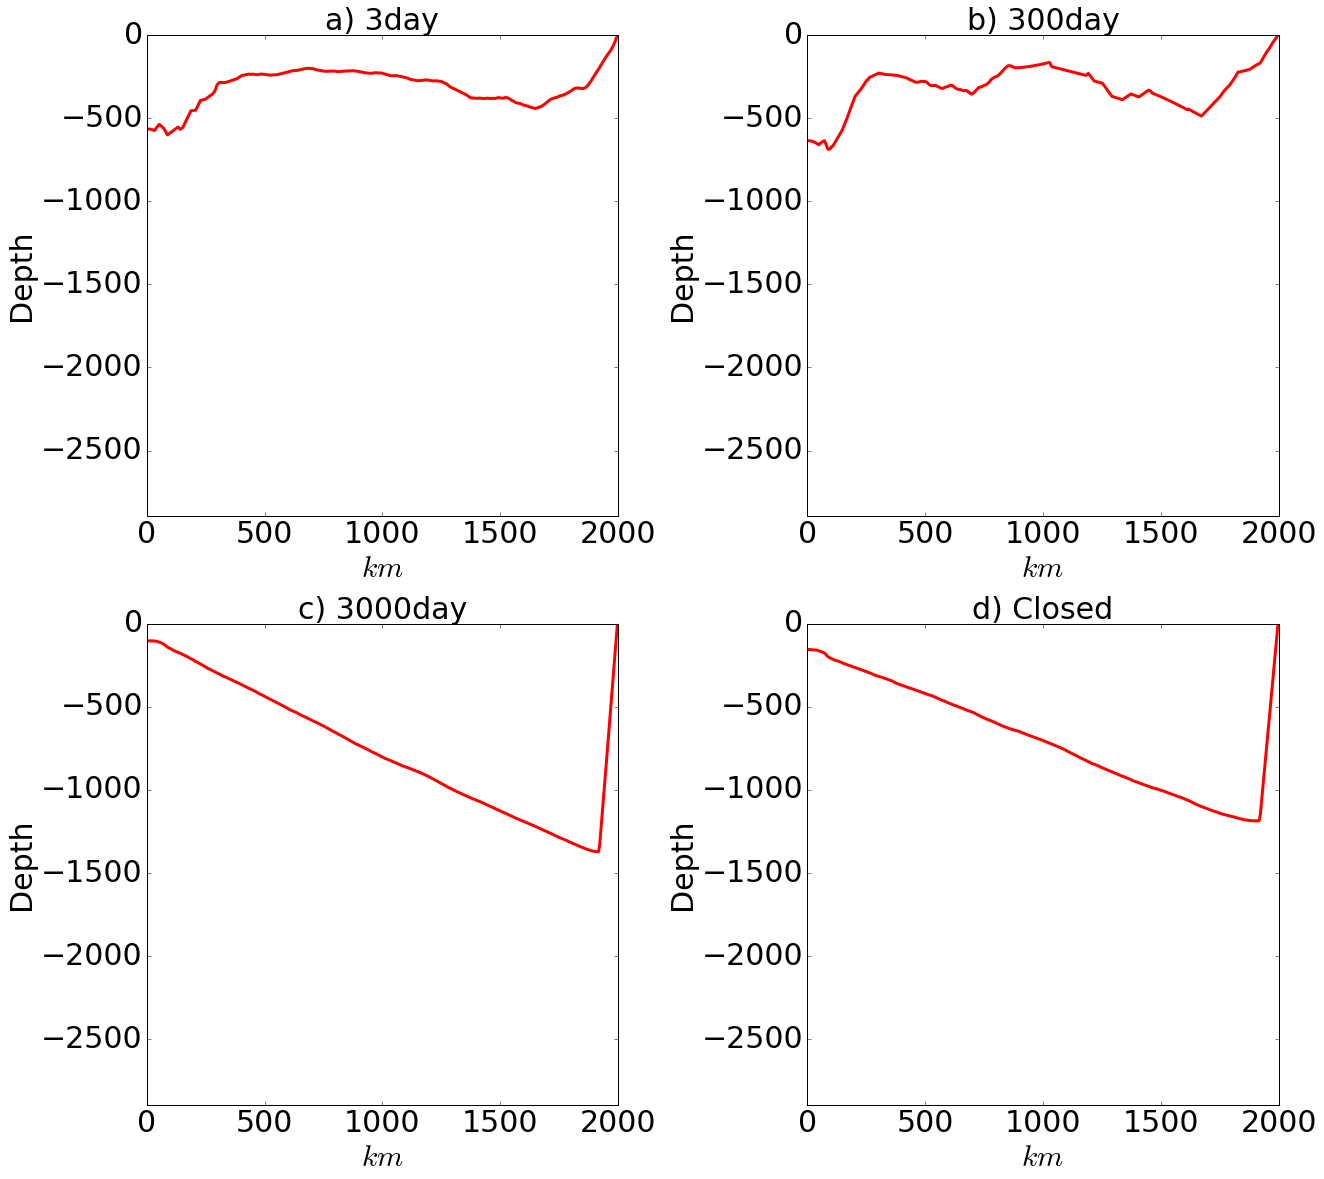

In [11]:
fig = plt.figure(figsize=(18.5, 16.5))
for i in range(len(Runs)):

    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    g = layers_calc_numba.LayersComputer(c)
    # ROC 
    psi = c.get_psi_iso()
    # Layer probability mask 
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    #psi = ma.masked_array(psi, PI < .98 )
    # Depths
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1],axis=0)[::-1]
    
    # Find Max ROC and depth of diabatic layer
    DDL = np.zeros(len(c.yc))

    for jj in range(len(c.yc)):
        if ma.all(PI[:,jj]  == 1)  or np.all(psi[:,jj] == -0) or PI[:,jj].mask.all():
            continue
        indx = ma.nonzero(PI[:,jj]<0.9999999999)[0]
        b = indx[np.nonzero(indx>3)[0]]
        if len(b)>=2 and (b[1]-b[0])>1:
            a = b[0]
        else:
            a = b[0]
            
        if a<41 and depths[a-1,jj] - depths[a,jj] > 150:
            DDL[jj] = (depths[a-1,jj]+depths[a,jj])/2
        else:
            DDL[jj] = depths[a,jj]

    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000, SG.savitzky_golay(-DDL,31,1), 'r', linewidth=3)
    plt.ylim(-2895,0)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel(r'$km$', fontsize=30)
    ax.set_ylabel(r'Depth', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()

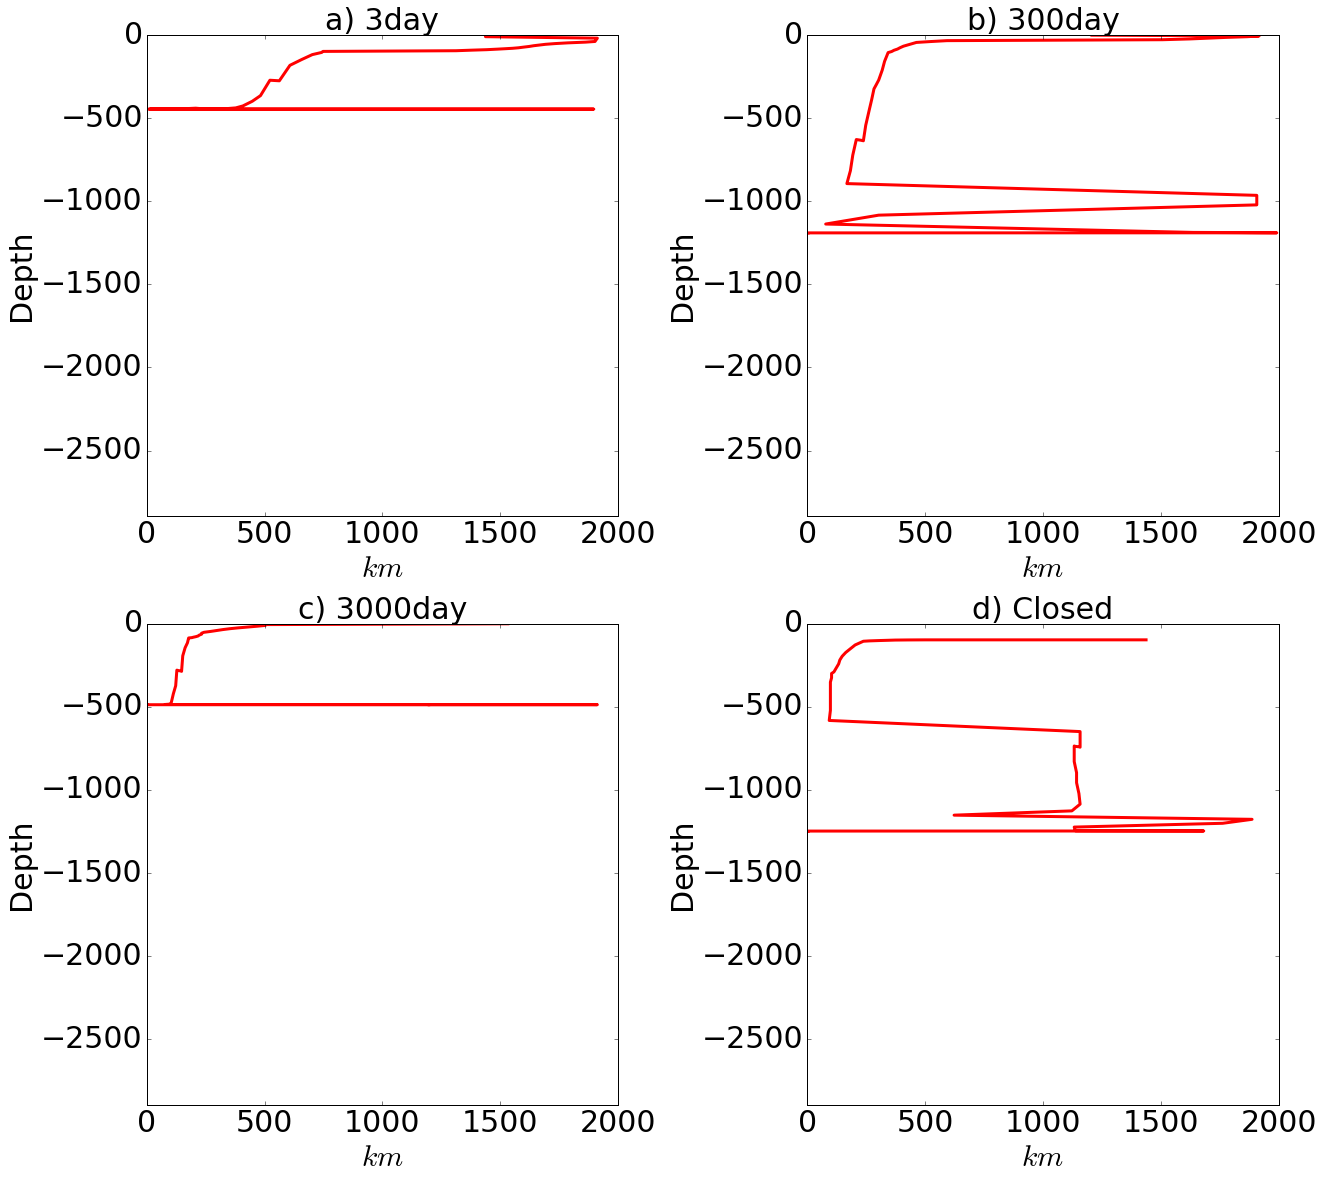

In [38]:
fig = plt.figure(figsize=(18.5, 16.5))
for i in range(len(Runs)):

    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    g = layers_calc_numba.LayersComputer(c)
    # ROC 
    psi = c.get_psi_iso()
    # Layer probability mask 
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    #psi = ma.masked_array(psi, PI < .98 )
    # Depths
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1],axis=0)[::-1]
    
    # Find Max ROC and depth of diabatic layer
    DDL = np.zeros(len(g.glvl))
    yy = np.zeros(len(g.glvl))
    for jj in range(len(g.glvl)):

        if np.nonzero(np.sign(np.mean(psi[jj,:])))[0]==1:
            a = np.where(psi[jj,:]==np.max(psi[jj,:]))[0]
        else:
            a = np.where(psi[jj,:]==np.min(psi[jj,:]))[0]      
        DDL[jj] = depths[jj,a[0]]
        yy[jj] = c.yc[a[0]]
     
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(yy/1000,SG.savitzky_golay(-DDL,31,1), 'r', linewidth=3)
    plt.ylim(-2895,0)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel(r'$km$', fontsize=30)
    ax.set_ylabel(r'Depth', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()

**ROC at diabatic layer depth**

* As above and take the ROC at this depth
* One extra clause: check a big surface wind driven circulation isnt being picked up!

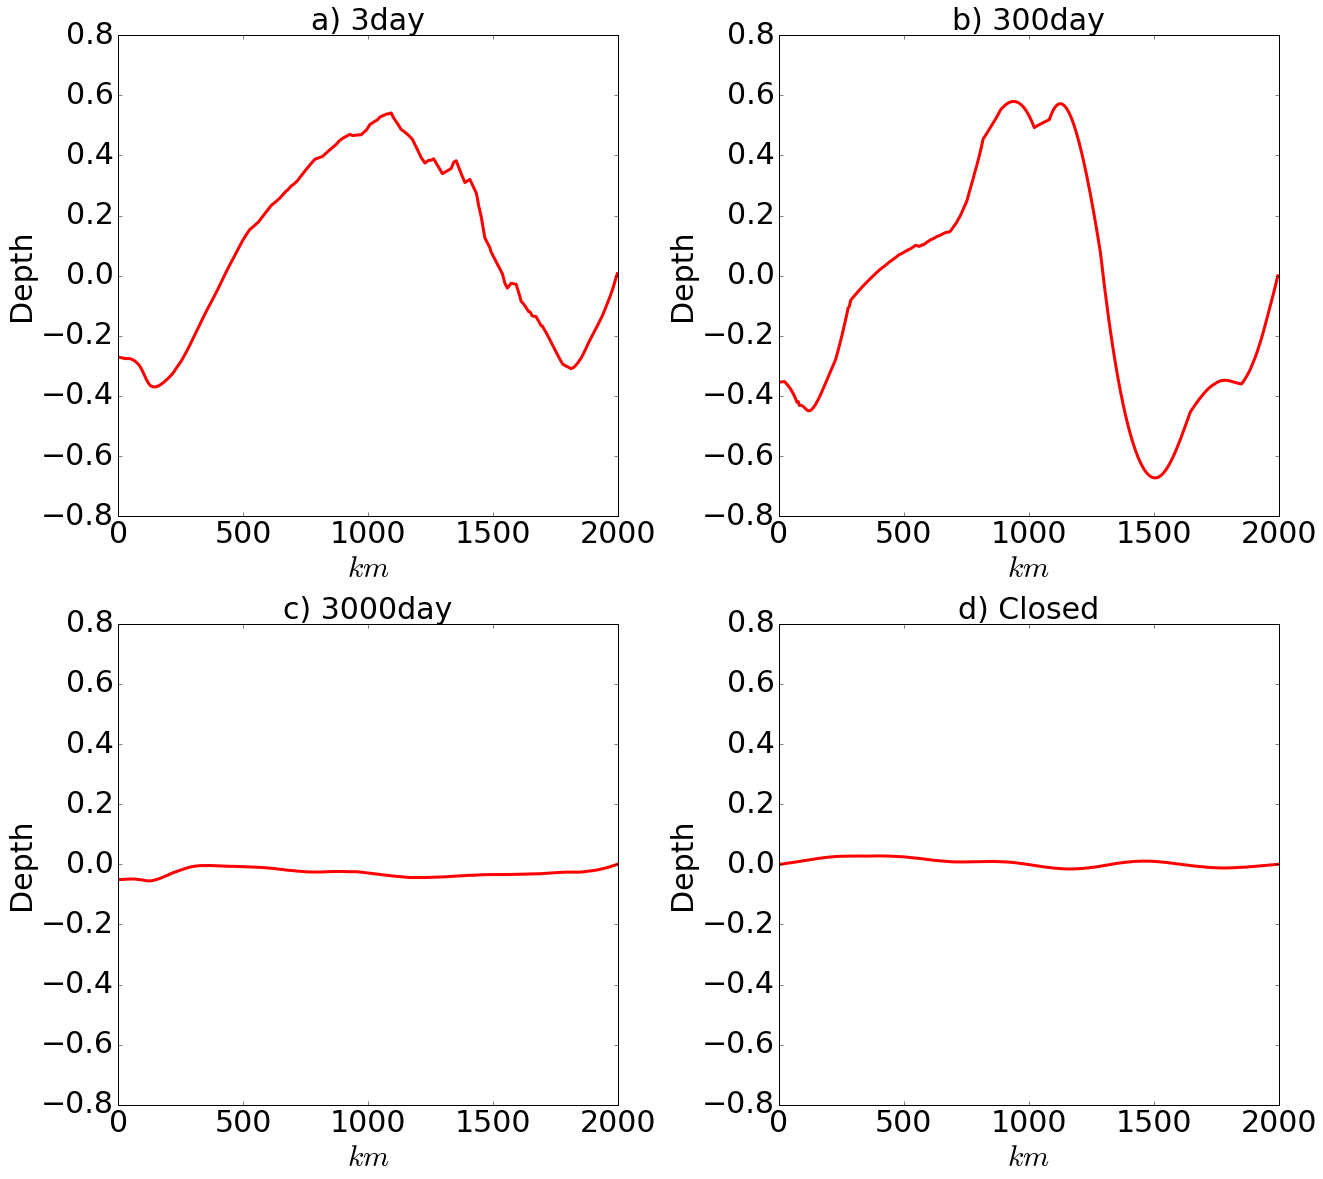

In [26]:
fig = plt.figure(figsize=(18.5, 16.5))
for i in range(len(Runs)):

    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    g = layers_calc_numba.LayersComputer(c)
    # ROC 
    psi = c.get_psi_iso()
    # Layer probability mask 
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    #psi = ma.masked_array(psi, PI < .98 )
    # Depths
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1],axis=0)[::-1]
    
    # Find Max ROC and depth of diabatic layer
    DDL = np.zeros(len(c.yc)) 
    ROC = np.zeros(len(c.yc)) 
    
    for jj in range(len(c.yc)):
        if ma.all(PI[:,jj]  == 1)  or np.all(psi[:,jj] == -0) or PI[:,jj].mask.all():
            continue
        indx = ma.nonzero(PI[:,jj]<1)[0]
        b = indx[np.nonzero(indx>3)[0]]
        if len(b)>=2 and (b[1]-b[0])>1:
            a = b[1]
        else:
            a = b[0]
        if a<41 and depths[a-1,jj] - depths[a,jj] > 150:
            a = a-1
        DDL[jj] = depths[a,jj]
        if psi[a,jj]/10**6 > 1.0:
            a = a-1
        ROC[jj] = psi[a,jj]
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000, SG.savitzky_golay(ROC,41,1)/10**6, 'r', linewidth=3)
    plt.ylim(-.8,.8)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel(r'$km$', fontsize=30)
    ax.set_ylabel(r'Depth', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()

** ROC maxima **
* find ROC maxima within a few layers depth of DDL
* find max abs and put back the sign 

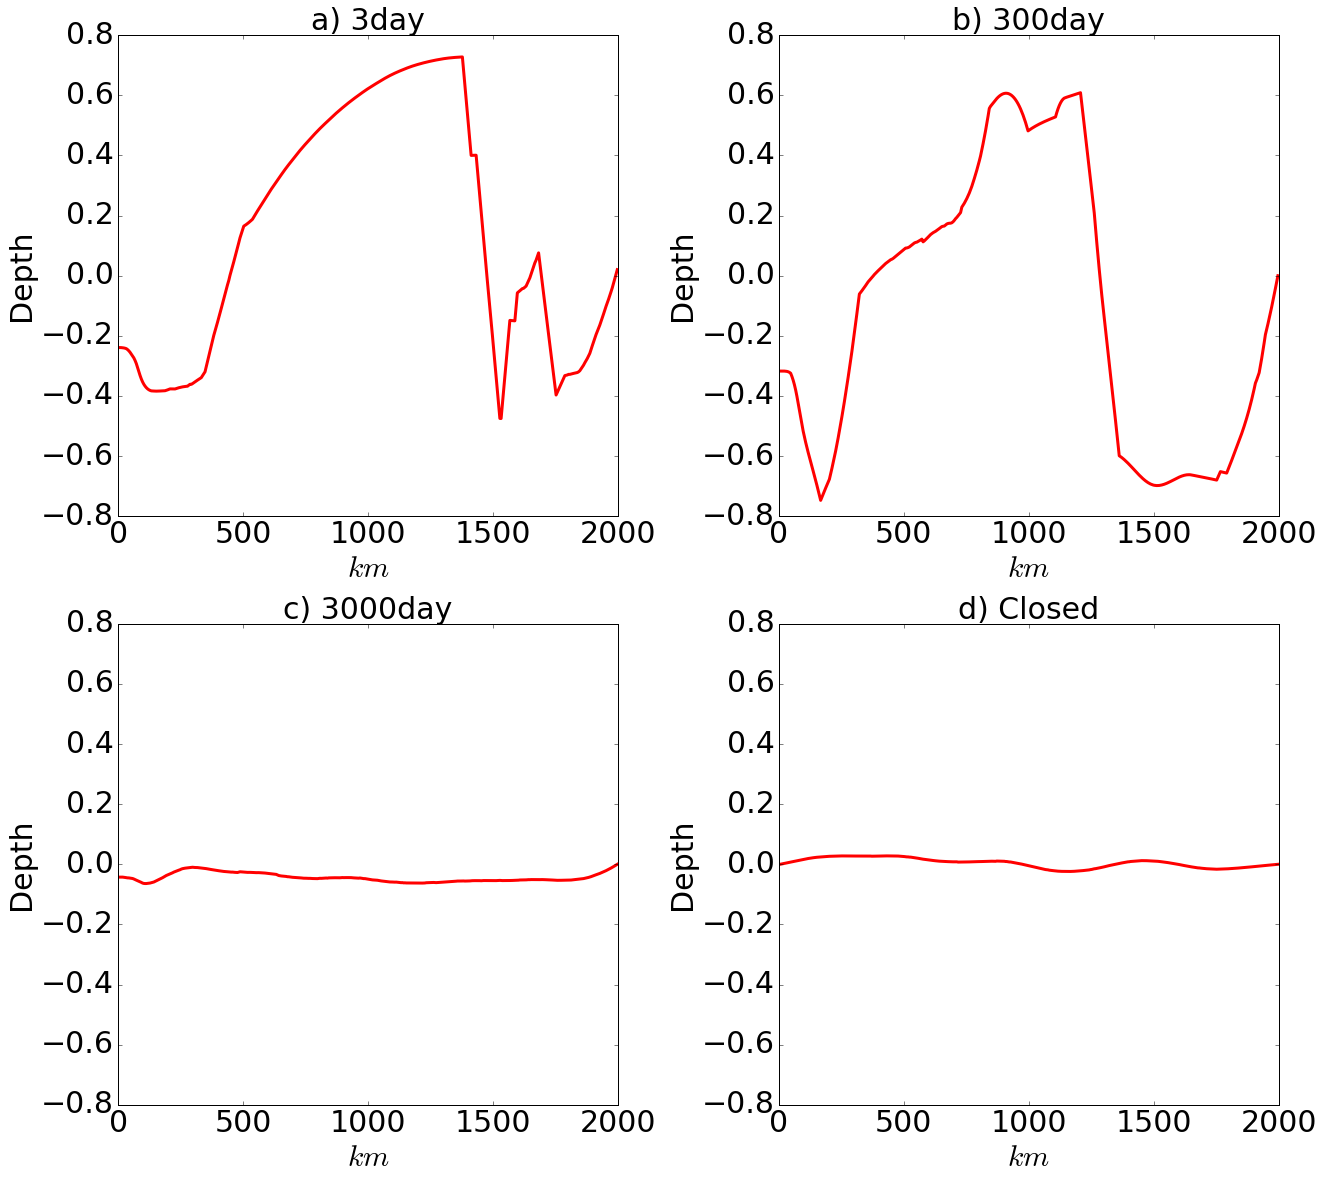

In [610]:
fig = plt.figure(figsize=(18.5, 16.5))
for i in range(len(Runs)):

    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    g = layers_calc_numba.LayersComputer(c)
    # ROC 
    psi = c.get_psi_iso()
    # Layer probability mask 
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    #psi = ma.masked_array(psi, PI < .98 )
    # Depths
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1],axis=0)[::-1]
    
    # Find Max ROC and depth of diabatic layer
    DDL = np.zeros(len(c.yc)) 
    ROC = np.zeros(len(c.yc)) 
    for jj in range(len(c.yc)):
        if ma.all(PI[:,jj]  == 1)  or np.all(psi[:,jj] == -0) or PI[:,jj].mask.all():
            continue
        indx = ma.nonzero(PI[:,jj]<1)[0]
        b = indx[np.nonzero(indx>3)[0]]
        if len(b)>=2 and (b[1]-b[0])>1:
            a = b[1]
        else:
            a = b[0]
        if a<41 and depths[a-1,jj] - depths[a,jj] > 150:
            a = a-1
        DDL[jj] = depths[a,jj]
        if psi[a,jj]/10**6 > 1.0:
            a = a-1
        ROC[jj] =  np.max(abs(psi[a-3:a+1,jj]))*np.sign(psi[a,jj])
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000, SG.savitzky_golay(ROC,31,1)/10**6, 'r', linewidth=3)
    q = plt.plot(c.yc/1000, (Psipred/c.dzc[0])*10**6, 'r', linewidth=3)
    plt.ylim(-.8,.8)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel(r'$km$', fontsize=30)
    ax.set_ylabel(r'Depth', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()

** Compare with Q **

1. with ROC at DDL

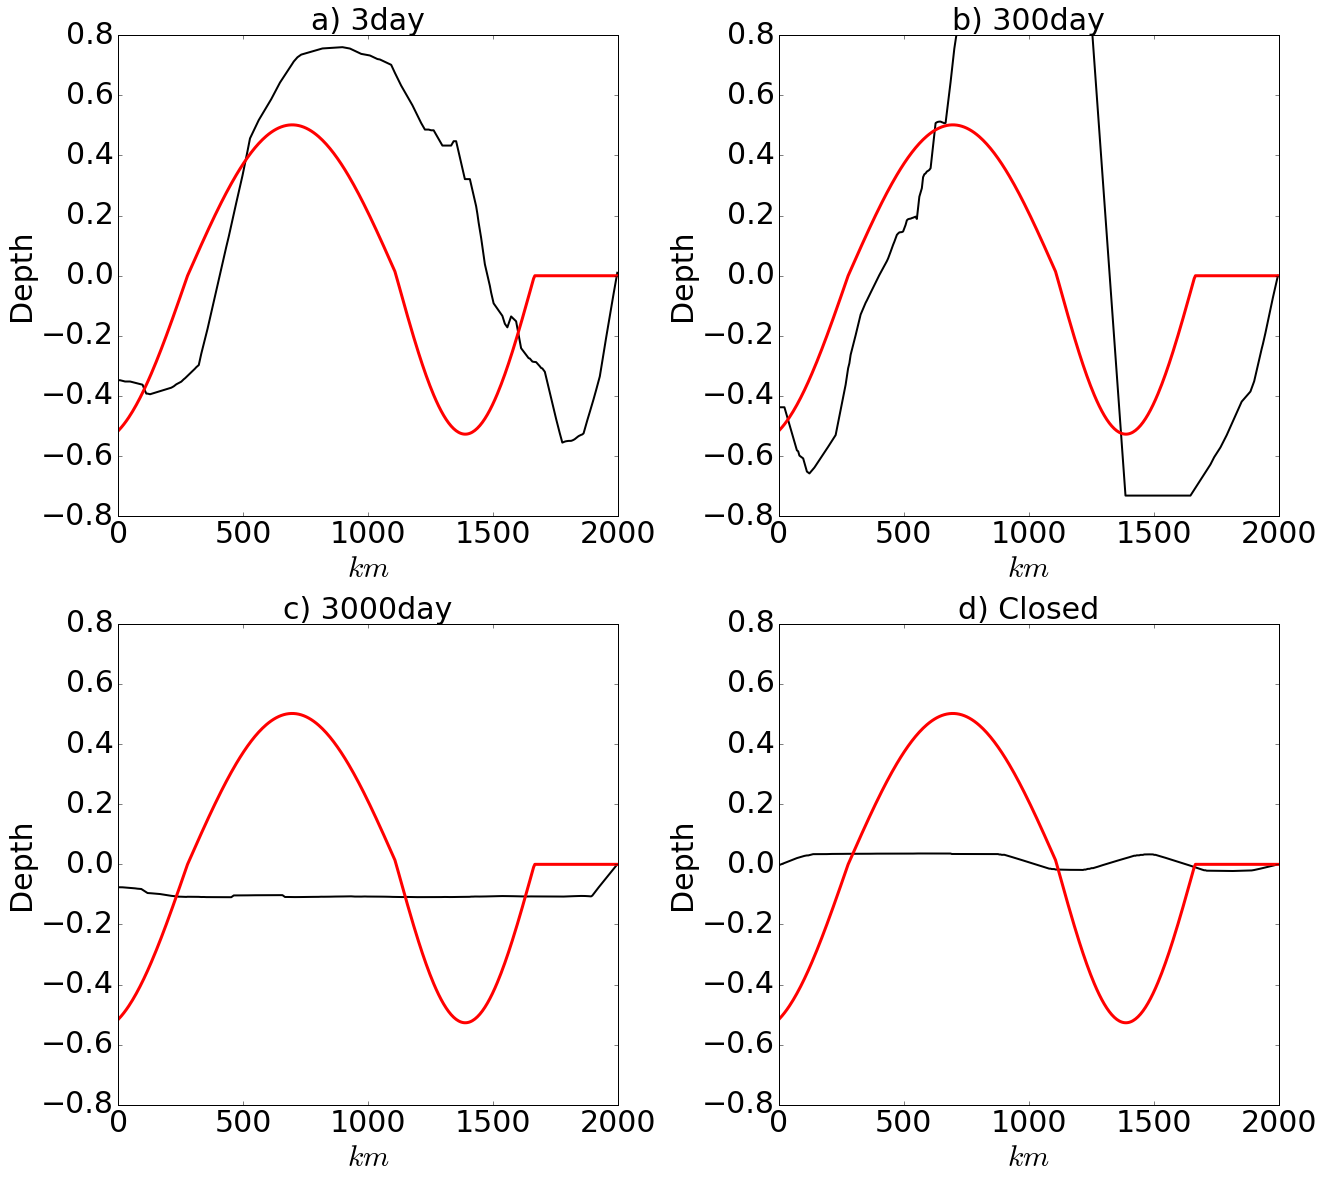

In [44]:
fig = plt.figure(figsize=(18.5, 16.5))
for i in range(len(Runs)):

    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    g = layers_calc_numba.LayersComputer(c)
    # ROC 
    psi = c.get_psi_iso()
    # Layer probability mask 
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    #psi = ma.masked_array(psi, PI < .98 )
    # Depths
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1],axis=0)[::-1]
    
    # Find Max ROC and depth of diabatic layer
    DDL = np.zeros(len(c.yc)) 
    ROC = np.zeros(len(c.yc)) 
    for jj in range(len(c.yc)):
        if ma.all(PI[:,jj]  == 1)  or np.all(psi[:,jj] == -0) or PI[:,jj].mask.all():
            continue
        indx = ma.nonzero(PI[:,jj]<1)[0]
        b = indx[np.nonzero(indx>3)[0]]
        if len(b)>=2 and (b[1]-b[0])>1:
            a = b[1]
        else:
            a = b[0]
        if a<41 and depths[a-1,jj] - depths[a,jj] > 150:
            a = a-1
        DDL[jj] = depths[a,jj]
        if psi[a,jj]/10**6 > 1.0:
            a = a-1
        if np.sign(psi[a,jj])==1:
            ROC[jj] = np.max(psi[a:a+3,:])
        else: 
            ROC[jj] = np.min(psi[a,:])
    Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000 * 3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000, SG.savitzky_golay(ROC,41,1)/10**6, 'k', linewidth=2)
    q = plt.plot(c.yc/1000, (Psipred/c.dzc[0])*10**6, 'r', linewidth=3)
    plt.ylim(-.8,.8)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel(r'$km$', fontsize=30)
    ax.set_ylabel(r'Depth', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()

2. With ROC maxima

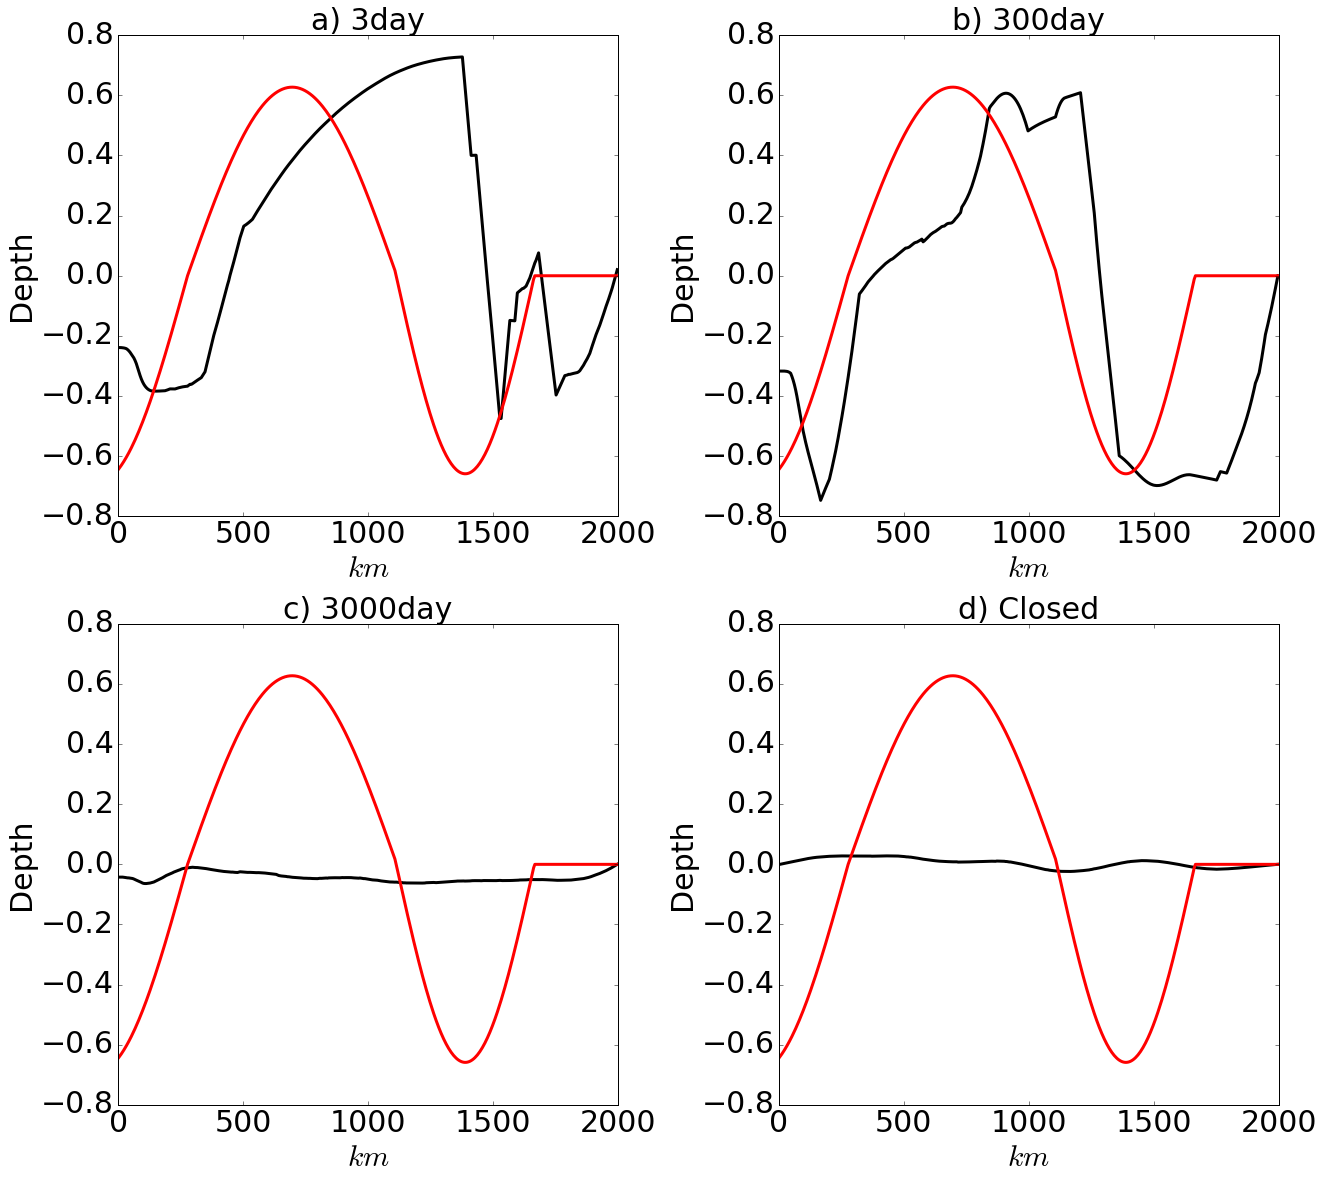

In [620]:
fig = plt.figure(figsize=(18.5, 16.5))
for i in range(len(Runs)):

    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    g = layers_calc_numba.LayersComputer(c)
    # ROC 
    psi = c.get_psi_iso()
    # Layer probability mask 
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    #psi = ma.masked_array(psi, PI < .98 )
    # Depths
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1],axis=0)[::-1]
    
    # Find Max ROC and depth of diabatic layer
    DDL = np.zeros(len(c.yc)) 
    ROC = np.zeros(len(c.yc)) 
    for jj in range(len(c.yc)):
        if ma.all(PI[:,jj]  == 1)  or np.all(psi[:,jj] == -0) or PI[:,jj].mask.all():
            continue
        indx = ma.nonzero(PI[:,jj]<1)[0]
        b = indx[np.nonzero(indx>3)[0]]
        if len(b)>=2 and (b[1]-b[0])>1:
            a = b[1]
        else:
            a = b[0]
        if a<41 and depths[a-1,jj] - depths[a,jj] > 150:
            a = a-1
        DDL[jj] = depths[a,jj]
        if psi[a,jj]/10**6 > 1.0:
            a = a-1
        ROC[jj] =  np.max(abs(psi[a-3:a+1,jj]))*np.sign(psi[a,jj])
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000, SG.savitzky_golay(ROC,31,1)/10**6, 'k', linewidth=3)
    q = plt.plot(c.yc/1000, (Psipred/4)*10**6, 'r', linewidth=3)
    plt.ylim(-.8,.8)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel(r'$km$', fontsize=30)
    ax.set_ylabel(r'Depth', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()

** Now add in Ty multiplication **

The neatest ROC calculated is a long DDL depth so lets try that first.

1. Ty from remapped layers temp 
2. Ty from THETA

Ty from THETA
Try just at surface values - theoreticall the same through out diabatic layer ;)

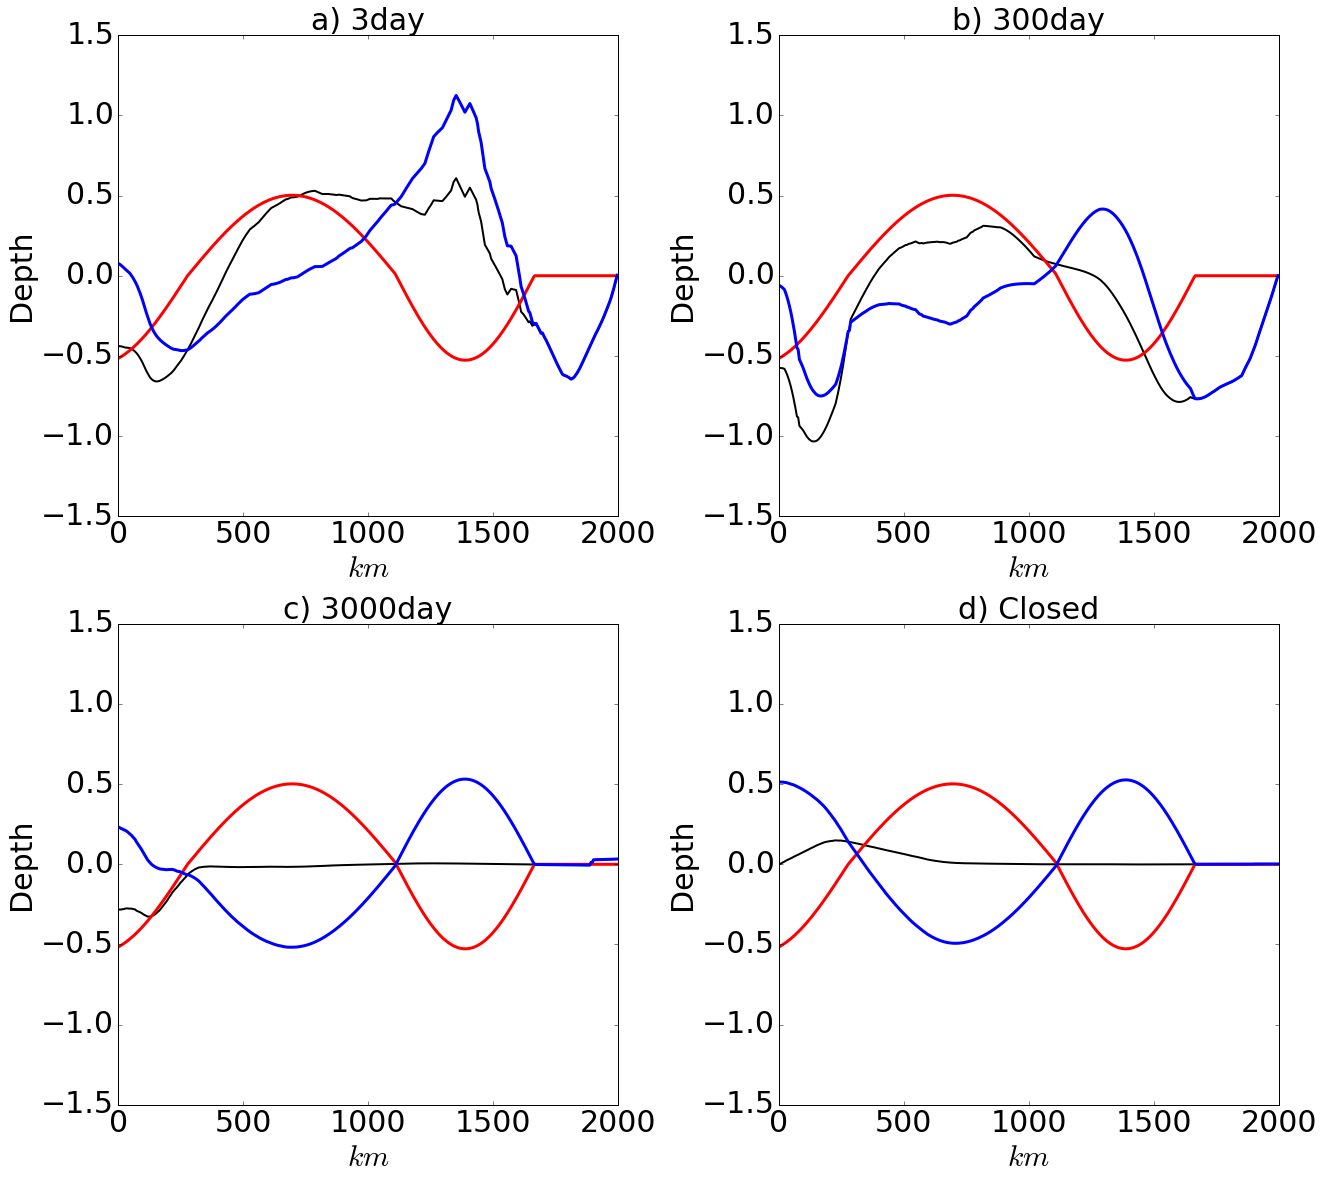

In [83]:
fig = plt.figure(figsize=(18.5, 16.5))
for i in range(len(Runs)):
    #i =0 
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    g = layers_calc_numba.LayersComputer(c)
    # ROC 
    psi = c.get_psi_iso()
    # Layer probability mask 
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    #psi = ma.masked_array(psi, PI < .98 )
    # Depths
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1],axis=0)[::-1]
    Temp = c.mnc('Tav.nc','THETA').mean(axis=2)
    Temp_smooth = np.apply_along_axis(utils.moving_average,0,Temp,3)
    npad = ((0,2),(0,0))
    Temp_sm = np.pad(Temp_smooth, pad_width=npad, mode='constant', constant_values=0)
    Ty = c.ddy_cgrid_centered(Temp_sm)
    # Find Max ROC and depth of diabatic layer
    DDL = np.zeros(len(c.yc)) 
    ROC = np.zeros(len(c.yc)) 
    TL = np.zeros(len(c.yc))
    for jj in range(len(c.yc)):
        if ma.all(PI[:,jj]  == 1)  or np.all(psi[:,jj] == -0) or PI[:,jj].mask.all():
            continue
        indx = ma.nonzero(PI[:,jj]<1)[0]
        b = indx[np.nonzero(indx>3)[0]]
        if len(b)>=2 and (b[1]-b[0])>1:
            a = b[1]
        else:
            a = b[0]
        if a<41 and depths[a-1,jj] - depths[a,jj] > 150:
            a = a-1
        DDL[jj] = depths[a,jj]
        TL[jj] = np.sum(g.glvl[a::]*th[a::,jj])/np.sum(th[a::,jj])
        if psi[a,jj]/10**6 > 1.0:
            a = a-1
        ROC[jj] = psi[a,jj]
        
    TLZ =-(np.tile(TL,(c.Nz,1)))
    TLy = c.ddy_cgrid_centered(TLZ)[0,:]
    Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000 * 3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000, SG.savitzky_golay(ROC*Ty[1,:],41,1), 'k', linewidth=2)
    q = plt.plot(c.yc/1000, (Psipred/c.dzc[0])*10**6, 'r', linewidth=3)
    r = plt.plot(c.yc/1000, (SG.savitzky_golay(ROC*Ty[1,:],41,1)-(Psipred/c.dzc[0])*10**6), 'b', linewidth=3)
    plt.ylim(-1.5,1.5)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel(r'$km$', fontsize=30)
    ax.set_ylabel(r'Depth', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)

plt.tight_layout()